In [1]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2


2022-12-13 11:38:34.763513: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import os 
!pip install -U -q segmentation-models --user
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [4]:
folder = '../input/chess5/data/'
image_size = (224,224)
batch_size = 32

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=5,
        #width_shift_range=0.1,
        #height_shift_range=0.1,
        rescale=1./255,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_gen = datagen.flow_from_directory(folder + 'train_data',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    classes = ['bb', 'bk', 'bn', 'bp', 'bq', 'br','empty', 'wb', 'wk', 'wn', 'wp', 'wq', 'wr'],
    shuffle=True  
)

test_gen = test_datagen.flow_from_directory(folder + 'test_data',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    classes = ['bb', 'bk', 'bn', 'bp', 'bq', 'br','empty', 'wb', 'wk', 'wn', 'wp', 'wq', 'wr'],
    shuffle=False 
)

Found 12696 images belonging to 13 classes.
Found 1846 images belonging to 13 classes.


In [7]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.imagenet_utils import decode_predictions

model = Xception( #  here is the pretrained model that we will be applying to our model
        include_top=False,
        weights= 'imagenet',
        input_shape=(224,224,3))


2022-12-13 11:39:07.678560: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-13 11:39:07.681854: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-13 11:39:07.745446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 11:39:07.746144: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-12-13 11:39:07.746204: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-12-13 11:39:07.773662: I tensorflow/stream_executor/platform/def

83689472/83683744 [==============================] - 4s 0us/step


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model

with strategy.scope():     
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
    # Freeze convolutional layers
    for layer in base_model.layers:
        layer.trainable = False   

    # Establish new fully connected block
    x = base_model.output
    x = Flatten()(x)  # flatten from convolution tensor output  
    x = Dense(500, activation='relu')(x) # number of layers and units are hyperparameters, as usual
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Dense(500, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    predictions = Dense(13, activation='softmax')(x) # should match # of classes predicted

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [17]:
# here we will define the callback settings for early stopping and saving

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 10, # stops if no min_delta improvement after 10 epochs
    min_delta = 0.05,
    mode = 'auto')
checkpoint_filepath = './'
save_best = tf.keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_categorical_accuracy:.3f}.h5',
    monitor = "val_categorical_accuracy",
    verbose = 0,
    save_best_only= True,
    mode = "max",
    save_freq = "epoch")

In [18]:
with strategy.scope():    
    history = model.fit(
        train_gen, 
        epochs=30,
        steps_per_epoch = 101,
        verbose = 1,
        validation_data=test_gen,
        callbacks = [early_stopping,save_best]
        )


Epoch 1/30
101/101 [==============================] - 66s 634ms/step - loss: 1.4086 - categorical_accuracy: 0.5795 - val_loss: 0.8464 - val_categorical_accuracy: 0.6977
Epoch 2/30
101/101 [==============================] - 63s 630ms/step - loss: 0.6709 - categorical_accuracy: 0.7909 - val_loss: 0.8053 - val_categorical_accuracy: 0.7151
Epoch 3/30
101/101 [==============================] - 68s 672ms/step - loss: 0.5323 - categorical_accuracy: 0.8278 - val_loss: 0.7693 - val_categorical_accuracy: 0.7113
Epoch 4/30
101/101 [==============================] - 66s 658ms/step - loss: 0.4509 - categorical_accuracy: 0.8576 - val_loss: 0.6625 - val_categorical_accuracy: 0.7600
Epoch 5/30
101/101 [==============================] - 66s 656ms/step - loss: 0.4747 - categorical_accuracy: 0.8309 - val_loss: 0.6110 - val_categorical_accuracy: 0.7714
Epoch 6/30
101/101 [==============================] - 66s 655ms/step - loss: 0.3742 - categorical_accuracy: 0.8751 - val_loss: 0.6709 - val_categorical_acc

Minimum validation loss: 0.13732610642910004


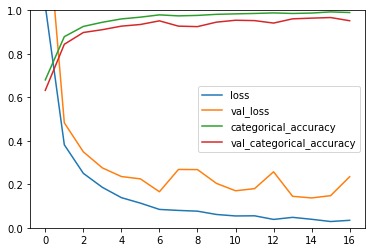

In [11]:
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

# plotting the loss and accuracy 
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss','categorical_accuracy','val_categorical_accuracy']].plot()
plt.ylim(0,1)
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [12]:
test_loss, test_acc = history.model.evaluate(test_gen, steps=50)
print('test_acc:',test_acc)
print('test_loss:',test_loss)

50/50 [==============================] - 5s 90ms/step - loss: 0.2684 - categorical_accuracy: 0.9463
test_acc: 0.9462500214576721
test_loss: 0.2684187591075897


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


2.1975


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

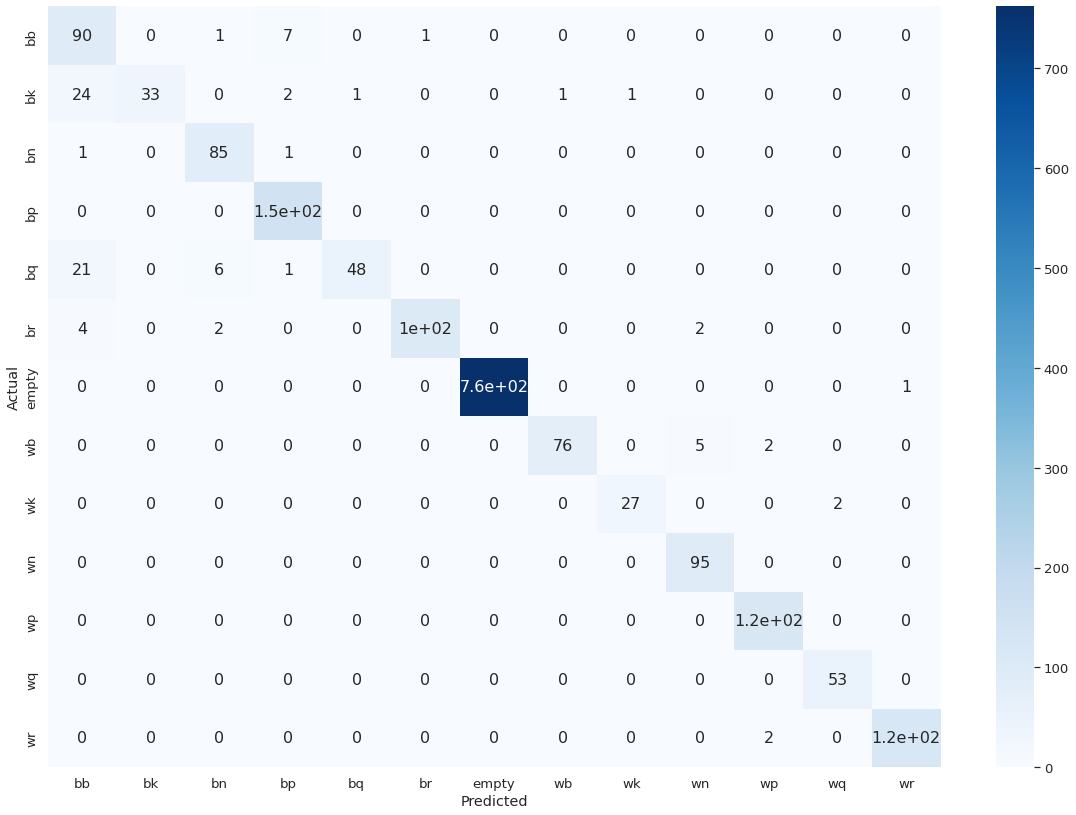

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['bb', 'bk', 'bn', 'bp', 'bq', 'br','empty', 'wb', 'wk', 'wn', 'wp', 'wq', 'wr']

test_gen.reset()
Y_pred = model.predict_generator(test_gen)
classes = test_gen.classes[test_gen.index_array]
y_pred = np.argmax(Y_pred, axis= -1)
print(sum(y_pred==classes)/800)


data = confusion_matrix(classes, y_pred)
df_cm = pd.DataFrame(data, columns=target_names, index = target_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (20,14))
sn.set(font_scale=1.2)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [14]:
print('Confusion Matrix')
print(data)
print('Classification Report')
print(classification_report(test_gen.classes[test_gen.index_array], y_pred, target_names=target_names))

Confusion Matrix
[[ 90   0   1   7   0   1   0   0   0   0   0   0   0]
 [ 24  33   0   2   1   0   0   1   1   0   0   0   0]
 [  1   0  85   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0 147   0   0   0   0   0   0   0   0   0]
 [ 21   0   6   1  48   0   0   0   0   0   0   0   0]
 [  4   0   2   0   0 102   0   0   0   2   0   0   0]
 [  0   0   0   0   0   0 762   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0  76   0   5   2   0   0]
 [  0   0   0   0   0   0   0   0  27   0   0   2   0]
 [  0   0   0   0   0   0   0   0   0  95   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 118   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  53   0]
 [  0   0   0   0   0   0   0   0   0   0   2   0 122]]
Classification Report
              precision    recall  f1-score   support

          bb       0.64      0.91      0.75        99
          bk       1.00      0.53      0.69        62
          bn       0.90      0.98      0.94        87
          bp       0.93     

In [ ]:
cv2.imwrite('./' + str(img_count) + '.jpeg', cropped)